In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
# 1. Load & Preprocess Data
data = pd.read_csv('Raisindata.csv')
data.dropna(inplace=True)


In [3]:
data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [4]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data['Class'] = data['Class'].map({'Kecimen': 0, 'Besni': 1})

In [5]:
data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,95347,451.526154,280.226153,0.784111,99256,0.674956,1255.245,0
1,61861,345.943650,235.430468,0.732706,67390,0.702280,1063.621,1
2,52693,283.504239,242.113954,0.520265,54860,0.737749,895.745,0
3,112808,542.504780,267.201878,0.870293,116961,0.743155,1390.400,1
4,49882,287.264327,222.185873,0.633852,50880,0.766378,843.764,0


In [6]:
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

In [7]:
X_train = train_data.drop(columns='Class').values
y_train = train_data['Class'].values
X_test = test_data.drop(columns='Class').values
y_test = test_data['Class'].values

In [8]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

In [10]:
print(X_train.shape)

torch.Size([720, 7])


In [ ]:
# 2 Define Neural Network Class
class ShallowNeuralNet:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases with gradient tracking
        self.W1 = torch.randn(input_size, hidden_size, requires_grad=True)
        self.b1 = torch.zeros(1, hidden_size, requires_grad=True)
        self.W2 = torch.randn(hidden_size, output_size, requires_grad=True)
        self.b2 = torch.zeros(1, output_size, requires_grad=True)

    def forward(self, X):
        """
        Forward pass:
        X -> ReLU(W1*X + b1) -> Sigmoid(W2*a1 + b2)
        """
        self.z1 = X @ self.W1 + self.b1           # Linear transform 1
        self.a1 = torch.relu(self.z1)             # Activation 1 (ReLU)
        self.z2 = self.a1 @ self.W2 + self.b2     # Linear transform 2
        self.y_pred = torch.sigmoid(self.z2)      # Activation 2 (Sigmoid)
        return self.y_pred

    def compute_loss(self, y_true, y_pred):
        # Binary cross-entropy loss for binary classification
        return F.binary_cross_entropy(y_pred, y_true)

    def backward(self):
        # Compute gradients for all weights and biases
        self.loss.backward()

    def update_weights(self, lr):
        # Manually update weights using gradient descent
        with torch.no_grad():
            self.W1 -= lr * self.W1.grad
            self.b1 -= lr * self.b1.grad
            self.W2 -= lr * self.W2.grad
            self.b2 -= lr * self.b2.grad

            # Clear old gradients
            self.W1.grad.zero_()
            self.b1.grad.zero_()
            self.W2.grad.zero_()
            self.b2.grad.zero_()

    def train(self, X_train, y_train, epochs, lr):
        """
        Complete training loop:
        1. Forward pass
        2. Compute loss
        3. Backpropagation
        4. Update weights
        """
        self.losses = []
        self.accuracies = []

        for epoch in range(epochs):
            y_pred = self.forward(X_train)
            self.loss = self.compute_loss(y_train, y_pred)
            self.backward()
            self.update_weights(lr)

            # Track performance
            pred_labels = y_pred.detach().numpy() > 0.5
            acc = accuracy_score(y_train, pred_labels)
            self.losses.append(self.loss.item())
            self.accuracies.append(acc)

            if epoch % 100 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}: Loss = {self.loss.item():.4f}, Accuracy = {acc * 100:.2f}%")

    def evaluate(self, X_test, y_test):
        # Make predictions on test set
        with torch.no_grad():
            y_pred = self.forward(X_test)
            preds = y_pred > 0.5
            acc = accuracy_score(y_test, preds)
            print(f"Test Accuracy: {acc * 100:.2f}%")
            return preds

    def plot_metrics(self):
        # Plot loss and accuracy trends
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.losses)
        plt.title("Loss over Epochs")
        plt.subplot(1, 2, 2)
        plt.plot(self.accuracies)
        plt.title("Accuracy over Epochs")
        plt.show()

In [ ]:
# 3. Train the Model
input_size = X_train.shape[1]
hidden_size = 10
output_size = 1
lr = 0.1
epochs = 1000

model = ShallowNeuralNet(input_size, hidden_size, output_size)
model.train(X_train, y_train, epochs, lr)

Epoch 0: Loss = 1.9947, Accuracy = 31.53%
Epoch 100: Loss = 0.3628, Accuracy = 84.86%
Epoch 200: Loss = 0.3417, Accuracy = 85.83%
Epoch 300: Loss = 0.3350, Accuracy = 86.11%
Epoch 400: Loss = 0.3309, Accuracy = 86.39%
Epoch 500: Loss = 0.3273, Accuracy = 86.11%
Epoch 600: Loss = 0.3252, Accuracy = 86.25%
Epoch 700: Loss = 0.3235, Accuracy = 86.81%
Epoch 800: Loss = 0.3219, Accuracy = 86.67%
Epoch 900: Loss = 0.3205, Accuracy = 86.67%
Epoch 999: Loss = 0.3192, Accuracy = 86.67%


In [ ]:
# 4. Evaluate Model
y_pred_test = model.evaluate(X_test, y_test)

Test Accuracy: 91.67%


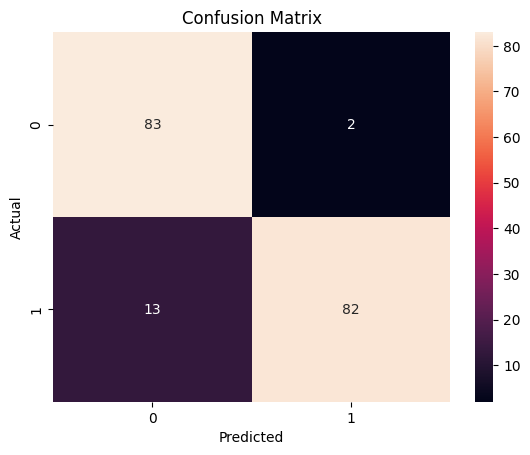

In [ ]:
# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

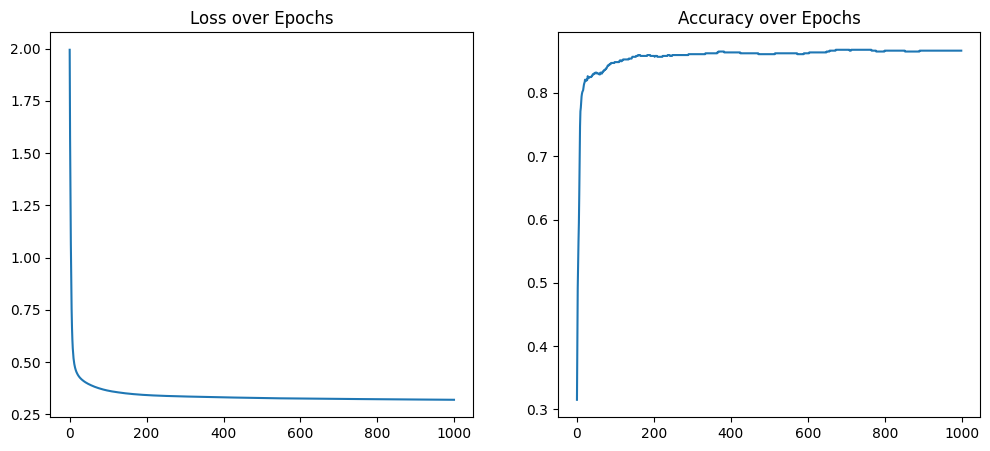

In [ ]:
# Plot Loss & Accuracy
model.plot_metrics()